In [1]:



import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torchvision
import torchvision.models as models
import sys
    # caution: path[0] is reserved for script path (or '' in REPL)
from torch import Tensor

import json
import numpy as np
import os
import pandas as pd
import re

import matplotlib.pyplot as plt

In [2]:
#create training plot



output = torch.load('saved_output/vgg16_new_validating_output/output_e0_b64')

model_name = "vgg19_pretrained"

In [3]:
#find max epoch and max batch  
output_files = [ i for i in os.listdir(f'saved_output/{model_name}_validating_output/') if 'output' in i]
output_files
max_b=0
max_e = 0
for output_file in output_files:
    of = re.findall('\d+$',output_file)
    if int(of[0]) > max_b:
        max_b = int(of[0])
    a= output_file.split('_')
    if int(a[1][1:]) >= max_e:
        max_e = int(a[1][1:])
    



def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred_t = pred.t()

    correct = pred_t.eq(target.view(1, -1).expand_as(pred_t))

    nb_classes = 185

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    _, preds = torch.max(output, 1)
    
    for t, p in zip(target.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    # print(confusion_matrix)
    
    
    # print(confusion_matrix.diag()/confusion_matrix.sum(1))
        
    res = []
    for k in topk:
    	correct_k = torch.sum(torch.reshape(correct[:k],(-1,) ).float()) #.double().sum(0)
    	res.append(correct_k.mul_(100.0 / batch_size))
    res.append(confusion_matrix)
    return res


In [229]:
prec1_list = []
prec1_avg_list = []
prec1_avg_list_temp = []
prec5_list = []
prec5_avg_list = []
prec5_avg_list_temp = []

best_epoch = 0
best_epoch_avg = 0

best_epoch_avg_5 = 0
for e in range(max_e+1):
    for b in range(max_b+1):
        output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')
        
        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))

        prec1_list.append(prec1.cpu())
        prec1_avg_list_temp.append(prec1.cpu())

        prec5_list.append(prec5.cpu())
        prec5_avg_list_temp.append(prec5.cpu())
    
    if best_epoch_avg < np.average(prec1_avg_list_temp):
        best_epoch_avg = np.average(prec1_avg_list_temp)
        best_epoch = e
        best_epoch_avg_5 =np.average(prec5_avg_list_temp)
        
    prec1_avg_list.append(np.average((prec1_avg_list_temp)))
    prec1_avg_list_temp = []


    prec5_avg_list.append(np.average(prec5_avg_list_temp))
    prec5_avg_list_temp = []
    
print('best epoch')
print(best_epoch,best_epoch_avg,'prec5:',best_epoch_avg_5)

best epoch
38 92.383514 prec5: 98.991936


In [178]:
prec1_array = np.array(prec1_list)
prec1_array_avg = np.array(prec1_avg_list)

prec5_array = np.array(prec5_list)
prec5_array_avg = np.array(prec5_avg_list)

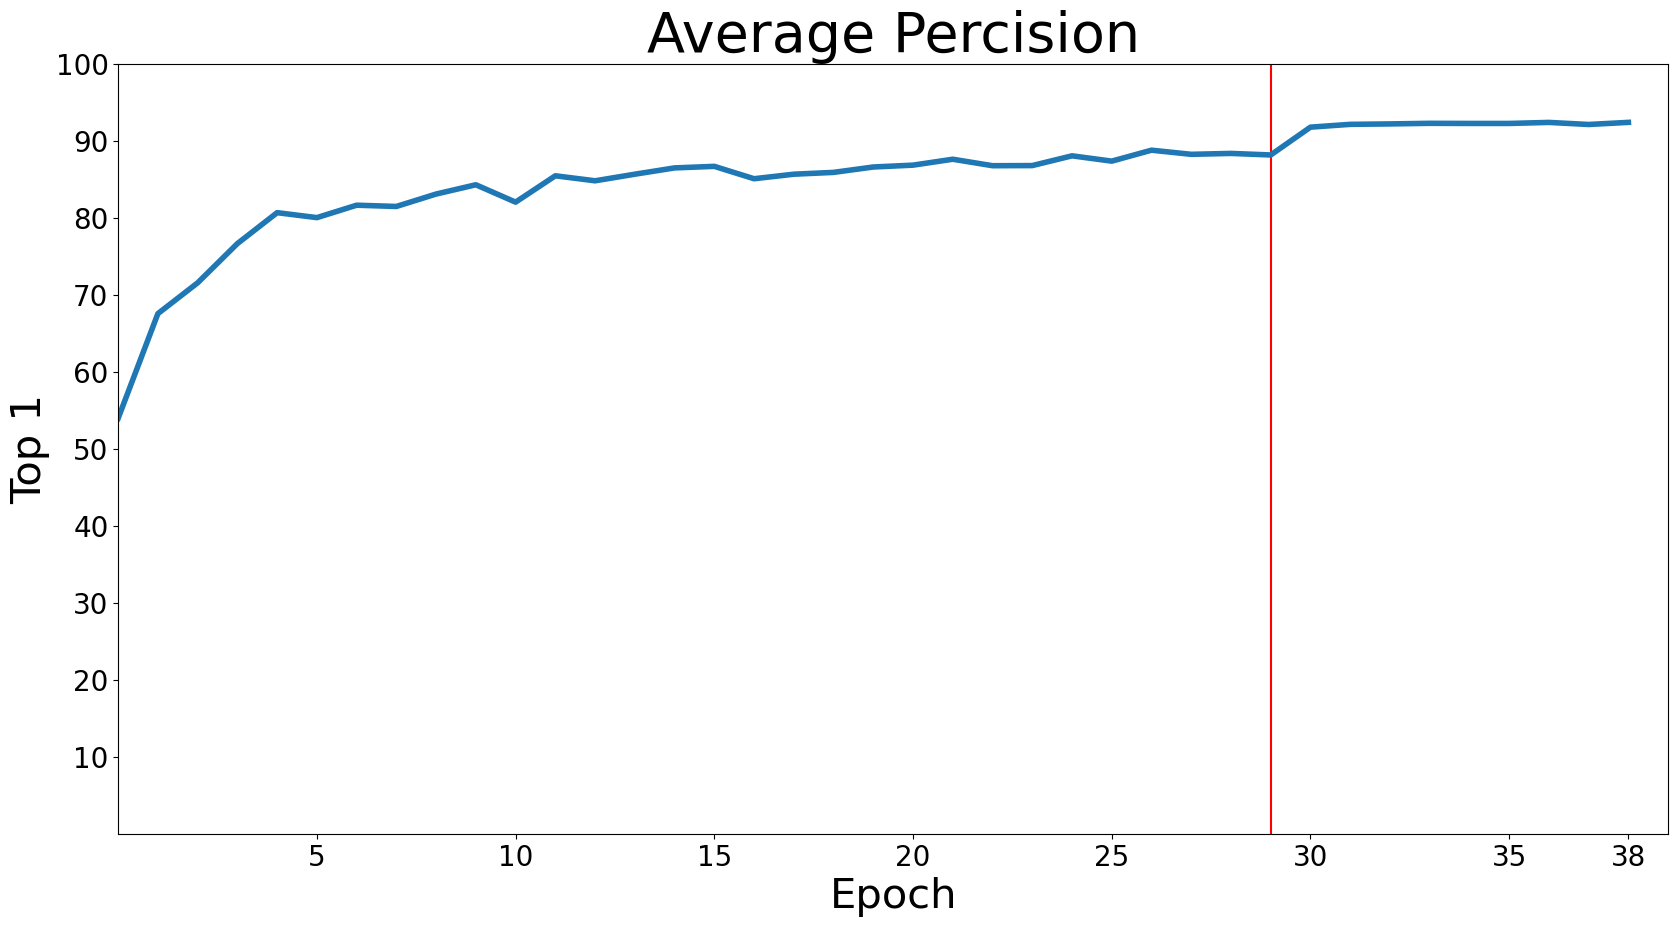

In [204]:
xticks_size = 20
yticks_size = 20
ylabel_size = 30
xlabel_size = 30 
title_size = 40
linewidth = 4

xticks = [5,10,15,20,25,30,35,38]


plt.figure(figsize=(20,10))

x = [i for i in range(len(prec1_array_avg[:39]))]
# plt.axvline(x = 15, color = 'r', label = 'axvline - full height')
plt.axvline(x = 29, color = 'r', label = 'axvline - full height')
# plt.axvline(x = 0, color = 'r', label = 'axvline - full height')
plt.xticks(xticks,fontsize=xticks_size)
plt.yticks([10,20,30,40,50,60,70,80,90,100],fontsize=yticks_size)
plt.ylabel('Top 1', fontsize=ylabel_size)
plt.xlabel('Epoch',fontsize=xlabel_size)
plt.title('Average Percision', fontsize=title_size)

# plt.margins(0)
plt.xlim([0, 39])
plt.ylim([0, 100])
plt.plot(x,prec1_array_avg[:39], linewidth = linewidth)

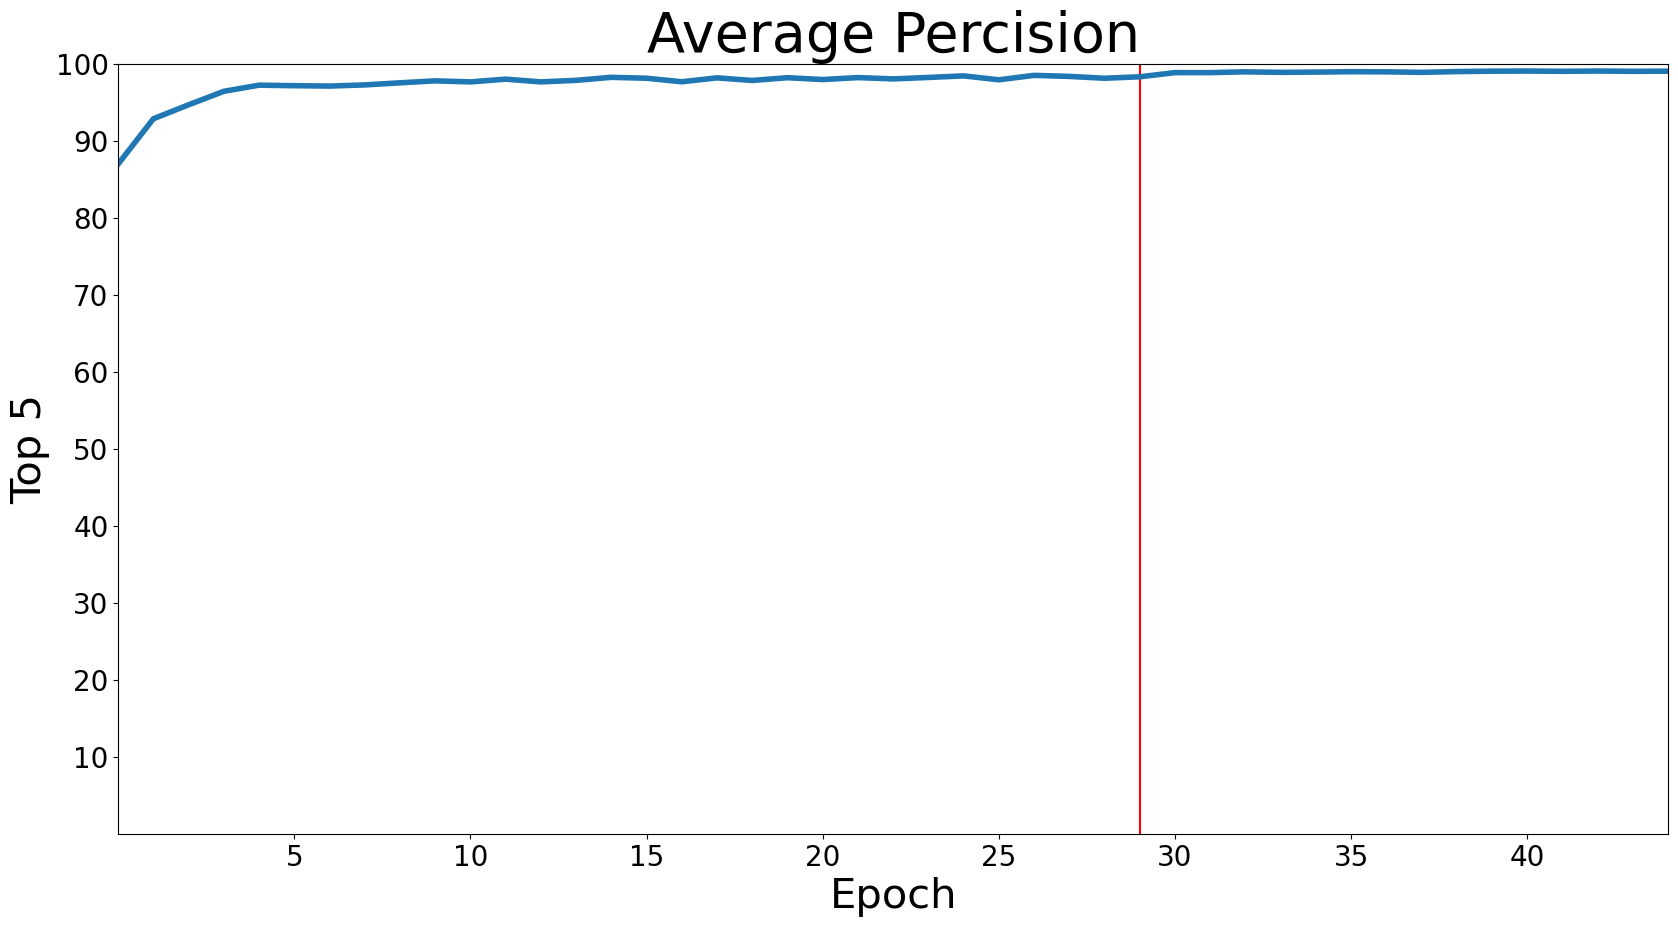

In [7]:
plt.figure(figsize=(20,10))
x = [i for i in range(len(prec5_array_avg))]
plt.axvline(x = 29, color = 'r', label = 'axvline - full height')
# plt.axvline(x = 20, color = 'r', label = 'axvline - full height')
plt.xticks(xticks,fontsize=xticks_size)
plt.yticks([10,20,30,40,50,60,70,80,90,100],fontsize=yticks_size)
plt.ylabel('Top 5', fontsize=ylabel_size)
plt.xlabel('Epoch',fontsize=xlabel_size)
plt.title('Average Percision', fontsize=title_size)

# plt.margins(0)
plt.xlim([0, max_e])
plt.ylim([0, 100])
plt.plot(x,prec5_array_avg, linewidth = linewidth)

In [27]:
##Loading data points
from pyproj import Proj, transform
import scipy.spatial as spatial

def convert_utm_to_latlon(df, zone_number, zone_letter):
    utm_proj = Proj(proj='utm', zone=zone_number, ellps='WGS84', south=(zone_letter < 'N'))
    lonlat_proj = Proj(proj='latlong', datum='WGS84')
    lon, lat = transform(utm_proj, lonlat_proj, df['Østkoordinat'].values, df['Nordkoordinat'].values)
    
    return pd.DataFrame({'Longitude': lon, 'Latitude': lat})



dat = pd.read_csv('C:/Users/vjosv/master/dataset/top185_in_oslo_area.csv')
dat = dat[['Id','Østkoordinat','Nordkoordinat','Vitenskapelig navn']]




dat['points']= [[i,j] for i, j in zip(dat.Østkoordinat, dat.Nordkoordinat)]

df_latlon = convert_utm_to_latlon(dat, 33, 'N') 


dat['lat']=df_latlon['Latitude']
dat['long']=df_latlon['Longitude']



#oslo area:
#lowerleft, upperleft, upper right, lower right,


lat_long_oslo = [(58.998141, 9.574585), (60.351413, 9.574585), (60.351413, 12.540894),(58.998141,12.540894)]

# dat['Østkoordinat']>lat_long_oslo[0][0]


dat = dat.loc[(dat['lat']>lat_long_oslo[0][0])  & (dat['lat']<lat_long_oslo[1][0]) & (dat['long']>lat_long_oslo[0][1 ]) & (dat['long']<lat_long_oslo[2][1])]





points = dat[['Østkoordinat','Nordkoordinat']].to_numpy()




point_tree = spatial.cKDTree(points)


science_names = dat['Vitenskapelig navn'].unique()
indexes = [i for i in range(len(dat['Vitenskapelig navn'].unique()))]



C:\Users\vjosv\AppData\Local\Temp\ipykernel_36912\1158250730.py:14: DtypeWarning: Columns (14,15,24,25,26,37,38,39,40,46) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv('C:/Users/vjosv/master/dataset/top185_in_oslo_area.csv')
C:\Users\vjosv\AppData\Local\Temp\ipykernel_36912\1158250730.py:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm_proj, lonlat_proj, df['Østkoordinat'].values, df['Nordkoordinat'].values)


In [9]:
# knn

output = torch.load('saved_output/vgg16_new_validating_output/output_e0_b64')

model_name = "vgg19_pretrained"

list_outputs = os.listdir(f'saved_output/{model_name}_validating_output/')


In [129]:
kde_outputs = []
for lo in list_outputs:
    if lo[:3] == 'kde':
        kde_outputs.append(lo)

In [147]:
kde_outputs[0]

side_len = [1000,2000,3000,4000]
bandwidth = [0.5,1,1.5]
configuration =[0,1,2]

def augment_output_add(output, augment, add):
    output_ = torch.nn.functional.softmax(output, dim=1)
    output_aug = output_ + add*augment
    output_aug = output_aug * 1/torch.sum(output_aug)
    
    return torch.log(output_aug)



In [208]:
prec1_list012 = []
prec1_avg_list012 = []
prec1_avg_list_temp012 = []


prec1_list0 = []
prec1_avg_list0 = []
prec1_avg_list_temp0 = []

prec1_list1 = []
prec1_avg_list1 = []
prec1_avg_list_temp1 = []

prec1_list2 = []
prec1_avg_list2 = []
prec1_avg_list_temp2 = []


prec5_list012 = []
prec5_avg_list012 = []
prec5_avg_list_temp012 = []

prec5_list0 = []
prec5_avg_list0 = []
prec5_avg_list_temp0 = []

prec5_list1 = []
prec5_avg_list1 = []
prec5_avg_list_temp1 = []

prec5_list2 = []
prec5_avg_list2 = []
prec5_avg_list_temp2 = []


add = 1.7

e = max_e
for e in range(max_e,max_e+1):
    for b in range(max_b+1):
        output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')

        tensor_list = []
        i = configuration[0]
        load_tensor0 =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{side_len[0]}m_bandwitdth{bandwidth[0]}_batch{b}_cofiguration{i}')
        tensor_list.append(load_tensor0.cuda())
        # tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3

        output = augment_output_add(output,load_tensor0.cuda(),add)


        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
        print(prec1)
        prec1_list0.append(prec1.cpu())
        prec1_avg_list_temp0.append(prec1.cpu())

        prec5_list0.append(prec5.cpu())
        prec5_avg_list_temp0.append(prec5.cpu())
        
        i = configuration[1]
        load_tensor1 =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{side_len[0]}m_bandwitdth{bandwidth[0]}_batch{b}_cofiguration{i}')
        tensor_list.append(load_tensor1.cuda())
        # tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3

        output = augment_output_add(output,load_tensor1.cuda(),add)


        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
        print(prec1)
        prec1_list1.append(prec1.cpu())
        prec1_avg_list_temp1.append(prec1.cpu())
        
        prec5_list1.append(prec5.cpu())
        prec5_avg_list_temp1.append(prec5.cpu())
        
        i = configuration[2]
        load_tensor2 =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{side_len[0]}m_bandwitdth{bandwidth[0]}_batch{b}_cofiguration{i}')
        tensor_list.append(load_tensor2.cuda())
        # tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3

        output = augment_output_add(output,load_tensor2.cuda(),add)


        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
        print(prec1)
        prec1_list2.append(prec1.cpu())
        prec1_avg_list_temp2.append(prec1.cpu())

        prec5_list2.append(prec5.cpu())
        prec5_avg_list_temp2.append(prec5.cpu())
        
        
        tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3
        
        output = augment_output_add(output,tensor_avg.cuda(),add)


        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
        print(prec1)
        print('-----------------------')
        prec1_list012.append(prec1.cpu())
        prec1_avg_list_temp012.append(prec1.cpu())

        prec5_list012.append(prec5.cpu())
        prec5_avg_list_temp012.append(prec5.cpu())
        
    prec1_avg_list0.append(np.average((prec1_avg_list_temp0)))
    prec1_avg_list_temp0 = []


    prec5_avg_list0.append(np.average(prec5_avg_list_temp0))
    prec5_avg_list_temp0 = []
    
    prec1_avg_list1.append(np.average((prec1_avg_list_temp1)))
    prec1_avg_list_temp1 = []


    prec5_avg_list1.append(np.average(prec5_avg_list_temp1))
    prec5_avg_list_temp1 = []
    
    prec1_avg_list2.append(np.average((prec1_avg_list_temp2)))
    prec1_avg_list_temp2 = []


    prec5_avg_list2.append(np.average(prec5_avg_list_temp2))
    prec5_avg_list_temp2 = []
    
        
    prec1_avg_list012.append(np.average((prec1_avg_list_temp012)))
    prec1_avg_list_temp012 = []


    prec5_avg_list012.append(np.average(prec5_avg_list_temp012))
    prec5_avg_list_temp012 = []



tensor(96.8750, device='cuda:0')
tensor(81.2500, device='cuda:0')
tensor(15.6250, device='cuda:0')
tensor(1.5625, device='cuda:0')
-----------------------
tensor(96.8750, device='cuda:0')
tensor(67.1875, device='cuda:0')
tensor(3.1250, device='cuda:0')
tensor(0., device='cuda:0')
-----------------------
tensor(96.8750, device='cuda:0')
tensor(85.9375, device='cuda:0')
tensor(4.6875, device='cuda:0')
tensor(0., device='cuda:0')
-----------------------
tensor(96.8750, device='cuda:0')
tensor(71.8750, device='cuda:0')
tensor(1.5625, device='cuda:0')
tensor(0., device='cuda:0')
-----------------------
tensor(98.4375, device='cuda:0')
tensor(93.7500, device='cuda:0')
tensor(3.1250, device='cuda:0')
tensor(0., device='cuda:0')
-----------------------
tensor(96.8750, device='cuda:0')
tensor(43.7500, device='cuda:0')
tensor(28.1250, device='cuda:0')
tensor(4.6875, device='cuda:0')
-----------------------
tensor(98.4375, device='cuda:0')
tensor(57.8125, device='cuda:0')
tensor(4.6875, device='c

In [273]:
prec1_list = [[],[],[],[]]
prec1_avg_list_aug = [[],[],[],[]]
prec1_avg_list_temp = [[],[],[],[]]



prec5_list = [[],[],[],[]]
prec5_avg_list_aug = [[],[],[],[]]
prec5_avg_list_temp = [[],[],[],[]]


add = 1.7

dict_df = [{'Side Length': [],
            'Bandwidth': [],
             'best epoch': [],
             'prec1 max': [], 
             'prec5 at best epoch': [],
            f'prec1 at epoch {best_epoch}':[]
             },
           {'Side Length': [],
            'Bandwidth': [],
             'best epoch': [],
             'prec1 max': [], 
             'prec5 at best epoch': [],
            f'prec1 at epoch {best_epoch}':[]
             },
           {'Side Length': [],
            'Bandwidth': [],
             'best epoch': [],
             'prec1 max': [], 
             'prec5 at best epoch': [],
            f'prec1 at epoch {best_epoch}':[]
             },
           {'Side Length': [],
            'Bandwidth': [],
             'best epoch': [],
             'prec1 max': [], 
             'prec5 at best epoch': [],
            f'prec1 at epoch {best_epoch}':[]
             }]
           



e = max_e

for sl in side_len:
    for bw in bandwidth:
        prec1_list = [[],[],[],[]]
        prec1_avg_list_aug = [[],[],[],[]]
        prec1_avg_list_temp = [[],[],[],[]]



        prec5_list = [[],[],[],[]]
        prec5_avg_list_aug = [[],[],[],[]]
        prec5_avg_list_temp = [[],[],[],[]]


#         for i in configuration:
#             for e in range(max_e+1):
#                 for b in range(max_b+1):
#                     output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
#                     target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')

#                     tensor_list = []
#                     load_tensor =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{sl}m_bandwitdth{bw}_batch{b}_cofiguration{i}')
#                     tensor_list.append(load_tensor.cuda())
#                     # tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3

#                     output = augment_output_add(output,load_tensor.cuda(),add)


#                     prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
#                     prec1_list[i].append(prec1.cpu())
#                     prec1_avg_list_temp[i].append(prec1.cpu())

#                     prec5_list[i].append(prec5.cpu())
#                     prec5_avg_list_temp[i].append(prec5.cpu())



#                 # print(np.average(prec1_avg_list_temp))
#                 prec1_avg_list_aug[i].append(np.average((prec1_avg_list_temp[i])))
#                 prec1_avg_list_temp[i] = []


#                 prec5_avg_list_aug[i].append(np.average((prec5_avg_list_temp[i])))
#                 prec5_avg_list_temp[i] = []





        e = max_e
        for e in range(max_e+1):
            for b in range(max_b+1):
                output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
                target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')

                tensor_list = []
                for i in configuration:
                    load_tensor =torch.load( f'saved_output/{model_name}_validating_output/kde_side_len{sl}m_bandwitdth{bw}_batch{b}_cofiguration{i}')
                    tensor_list.append(load_tensor.cuda())
                tensor_avg =(tensor_list[0]+tensor_list[1]+tensor_list[2])/3

                output = augment_output_add(output,tensor_avg.cuda(),add)


                prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))
                prec1_list[3].append(prec1.cpu())
                prec1_avg_list_temp[3].append(prec1.cpu())

                prec5_list[3].append(prec5.cpu())
                prec5_avg_list_temp[3].append(prec5.cpu())

    

            # print(np.average(prec1_avg_list_temp[3]))
            prec1_avg_list_aug[3].append(np.average((prec1_avg_list_temp[3])))
            prec1_avg_list_temp[3] = []

            prec5_avg_list_aug[3].append(np.average((prec5_avg_list_temp[3])))
            prec5_avg_list_temp[3] = []

        for i in [3]:#configuration+[3]:

            
            dict_df[i]['Side Length'].append(sl)
            dict_df[i]['Bandwidth'].append(bw)
            dict_df[i]['best epoch'].append(np.argmax(prec1_avg_list_aug[i]))
            dict_df[i]['prec1 max'].append(np.max(prec1_avg_list_aug[i]))
            dict_df[i]['prec5 at best epoch'].append(prec5_avg_list_aug[i][np.argmax(prec1_avg_list_aug[i])])
            dict_df[i][f'prec1 at epoch {best_epoch}'].append(np.max(prec1_avg_list_aug[i][best_epoch]))
            # print(dict_df)
            print(f'kde side length:{sl},bw: {bw} configuration {i}: best prec1 {np.max(prec1_avg_list_aug[i])} at epoch {np.argmax(prec1_avg_list_aug[i])},value {np.max(prec1_avg_list_aug[i][best_epoch])} at best epoch ')
            print(f'kde side length:{sl}, bw: {bw} configuration {i}: best prec5 {np.max(prec5_avg_list_aug[i])} at epoch {np.argmax(prec5_avg_list_aug[i])},value {np.max(prec5_avg_list_aug[i][best_epoch])} at best epoch ')
            print('\n')
            print(f'original prec1 at best epoch 38:{best_epoch_avg}','prec5:',best_epoch_avg_5)
            print('\n')



kde side length:1000,bw: 0.5 configuration 3: best prec1 92.61312103271484 at epoch 40,value 92.5179214477539 at best epoch 
kde side length:1000, bw: 0.5 configuration 3: best prec5 96.1861572265625 at epoch 30,value 96.0853500366211 at best epoch 


original prec1 at best epoch 38:92.38351440429688 prec5: 98.991936


kde side length:1000,bw: 1 configuration 3: best prec1 92.5179214477539 at epoch 42,value 92.5011215209961 at best epoch 
kde side length:1000, bw: 1 configuration 3: best prec5 96.74059295654297 at epoch 30,value 96.63978576660156 at best epoch 


original prec1 at best epoch 38:92.38351440429688 prec5: 98.991936


kde side length:1000,bw: 1.5 configuration 3: best prec1 92.48432159423828 at epoch 42,value 92.40031433105469 at best epoch 
kde side length:1000, bw: 1.5 configuration 3: best prec5 97.21102142333984 at epoch 30,value 96.99260711669922 at best epoch 


original prec1 at best epoch 38:92.38351440429688 prec5: 98.991936


kde side length:2000,bw: 0.5 configur

In [274]:
#print as latex table 
for i in [3]:#configuration+[3]:
    a = pd.DataFrame.from_dict(dict_df[i])
    print(a.to_latex())
    
    a.to_csv(f'kde_results_configuration{i}.csv')

\begin{tabular}{lrrrrrr}
\toprule
 & Side Lenght & Bandwidth & best epoch & prec1 max & prec5 at best epoch & prec1 at epoch 38 \\
\midrule
0 & 1000 & 0.500000 & 40 & 92.613121 & 96.152557 & 92.517921 \\
1 & 1000 & 1.000000 & 42 & 92.517921 & 96.572578 & 92.501122 \\
2 & 1000 & 1.500000 & 42 & 92.484322 & 96.925400 & 92.400314 \\
3 & 2000 & 0.500000 & 42 & 92.467522 & 96.538979 & 92.450722 \\
4 & 2000 & 1.000000 & 42 & 92.467522 & 97.076614 & 92.400314 \\
5 & 2000 & 1.500000 & 42 & 92.433922 & 97.446236 & 92.400314 \\
6 & 3000 & 0.500000 & 42 & 92.467522 & 96.690186 & 92.450722 \\
7 & 3000 & 1.000000 & 42 & 92.467522 & 97.160622 & 92.400314 \\
8 & 3000 & 1.500000 & 42 & 92.417122 & 97.580643 & 92.400314 \\
9 & 4000 & 0.500000 & 38 & 92.467522 & 96.824600 & 92.467522 \\
10 & 4000 & 1.000000 & 42 & 92.467522 & 97.244621 & 92.400314 \\
11 & 4000 & 1.500000 & 38 & 92.400314 & 97.715057 & 92.400314 \\
\bottomrule
\end{tabular}



In [257]:
dict_df[3]

{'Side Lenght': [],
 'Bandwidth': [],
 'best epoch': [],
 'prec1 max': [],
 'prec5 at best epoch': [],
 'prec1 at epoch 38': []}

In [246]:
{'Side Lenght': sl,
'Bandwidth': bw,
 'best epoch':np.argmax(prec1_avg_list_aug[0]),
 'prec1 max': np.max(prec1_avg_list_aug[0]), 
 'prec5 at best epoch': np.argmax(prec5_avg_list_aug[0]),
    f'prec1 at epoch {best_epoch}':np.max(prec5_avg_list_aug[0][best_epoch])}

dict_conf = [{'Side Lenght': [],
            'Bandwidth': [],
             'best epoch': [],
             'prec1 max': [], 
             'prec5 at best epoch': [],
            f'prec1 at epoch {best_epoch}':[]
             }]*3
print(dict_conf)

[{'Side Lenght': [], 'Bandwidth': [], 'best epoch': [], 'prec1 max': [], 'prec5 at best epoch': [], 'prec1 at epoch 38': []}, {'Side Lenght': [], 'Bandwidth': [], 'best epoch': [], 'prec1 max': [], 'prec5 at best epoch': [], 'prec1 at epoch 38': []}, {'Side Lenght': [], 'Bandwidth': [], 'best epoch': [], 'prec1 max': [], 'prec5 at best epoch': [], 'prec1 at epoch 38': []}]


In [239]:
sample_df = [[]*(len(configuration)+1)]

print(sample_df)

[[]]


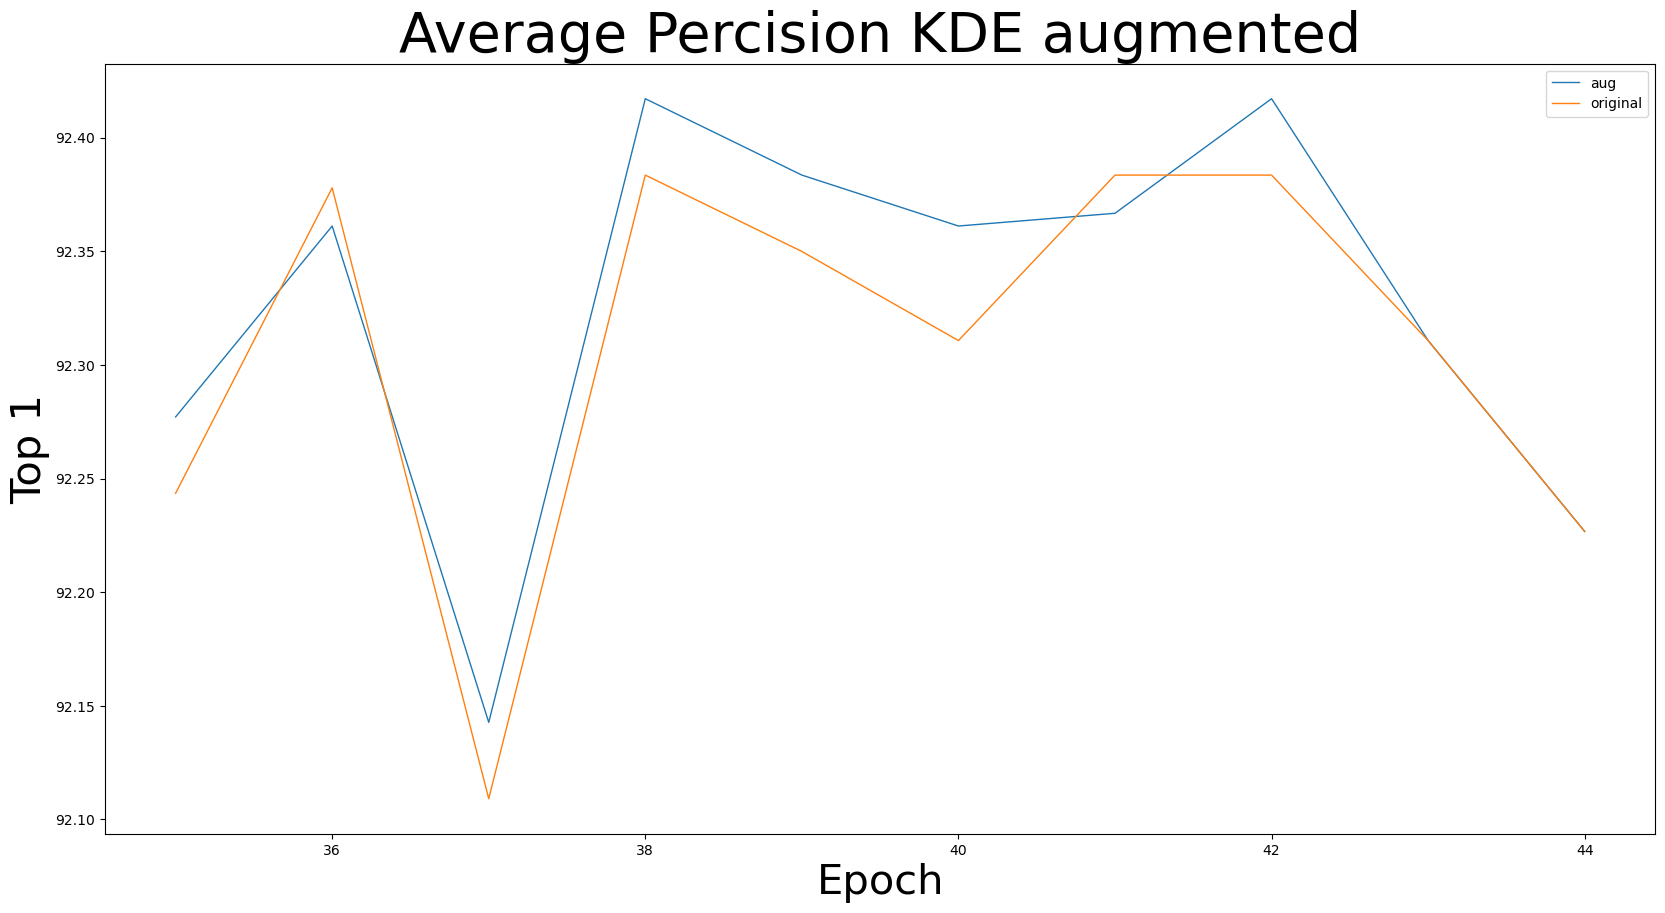

In [215]:
plt.figure(figsize=(20,10))
x = [i for i in range(len(prec1_avg_list_aug))]
# plt.axvline(x = 29, color = 'r', label = 'axvline - full height')
# plt.axvline(x = 20, color = 'r', label = 'axvline - full height')
# plt.xticks(xticks,fontsize=xticks_size)
# plt.yticks([10,20,30,40,50,60,70,80,90,100],fontsize=yticks_size)
plt.ylabel('Top 1', fontsize=ylabel_size)
plt.xlabel('Epoch',fontsize=xlabel_size)
plt.title('Average Percision KDE augmented', fontsize=title_size)
linewidth =1
# plt.margins(0)
# plt.xlim([0, max_e])
# plt.ylim([0, 100])

plt.plot(x[-10:],np.array(prec1_avg_list_aug)[-10:], linewidth = linewidth, label = "aug")
plt.plot(x[-10:],np.array(prec1_avg_list)[-10:], linewidth = linewidth, label = "original")
plt.legend() 


In [149]:
prec1_avg_list

[92.2267,
 92.2267,
 92.31071,
 92.32751,
 92.31071,
 92.31071,
 92.32751,
 92.32751,
 92.34431,
 92.34431,
 92.36111,
 92.36111,
 92.39471,
 92.39471,
 92.39471,
 92.39471,
 92.39471,
 92.428314,
 92.445114,
 92.428314,
 92.37791]

In [99]:
knn_outputs
import random
from tqdm import tqdm
import imblearn
import warnings
from scipy.stats import norm
from sklearn.neighbors import KNeighborsClassifier

# knn_smote_n_1000_batch0_cofiguration0

n_list = [100,200,500,1000,1500,2000,2500,3000]
n=0
config =[0,1,2]


random.seed(10)
names_mapping = []
index_mapping = []
for i in range(3):
    random.shuffle(indexes)
    names_mapping.append({science_name : index for (science_name,index) in zip(science_names,indexes)})
    index_mapping.append({index : science_name for (science_name,index) in zip(science_names,indexes)})

i=0
for b in range(max_b+1):
    # for i in config:
        load_tensor =torch.load( f'saved_output/{model_name}_validating_output/knn_smote_n_{n_list[n]}_batch{b}_cofiguration{i}')
        # output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
        # target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')
        print(load_tensor)
        break
        

[[0.15912526 0.15904423 0.1590746  ... 0.15903906 0.15902411 0.        ]
 [0.1590817  0.15906428 0.15913546 ... 0.15905421 0.15904464 0.15906959]
 [0.15907687 0.15901614 0.15896195 ... 0.15906912 0.15903046 0.15892604]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [126]:
#copied from Kevin Barnes/kbarnes3: https://gist.github.com/kbarnes3/3fb7d353e9bdd3efccd5

import ctypes
import platform

ES_CONTINUOUS = 0x80000000
ES_SYSTEM_REQUIRED = 0x00000001


def _set_thread_execution(state):
    ctypes.windll.kernel32.SetThreadExecutionState(state)


def prevent_standby():
    if platform.system() == 'Windows':
        _set_thread_execution(ES_CONTINUOUS | ES_SYSTEM_REQUIRED)


def allow_standby():
    if platform.system() == 'Windows':
        _set_thread_execution(ES_CONTINUOUS)


def long_running(func):
    def inner(*args, **kwargs):
        prevent_standby()
        result = func(*args, **kwargs)
        allow_standby()
        return result
    return inner


In [128]:
def sample_plant_position(plant,df,index):
    if type(plant) == str:
        return dat[dat['Vitenskapelig navn'] == plant].sample(1)
    elif type(plant) == int:
        return dat[dat['Vitenskapelig navn'] == index_mapping[index][plant]].sample(1)


def get_knn_classifier_smote(samples_pos_list,dat,n_list,configuration):
    i = configuration
    sample_pos_indexes = [sp.index[0] for sp in samples_pos_list if sp.index[0] in list(dat.index)]
    
    dat_removed_samples = dat.drop(index=sample_pos_indexes)
    category = []
    for k in dat_removed_samples['Vitenskapelig navn']:
        category.append(names_mapping[i][k])
        
    category = np.array(category)
    points_np= np.array(list(dat_removed_samples['points']))
    oversample = imblearn.over_sampling.KMeansSMOTE()
    warnings.filterwarnings("ignore")
    X, y = oversample.fit_resample(points_np, category) 
    warnings.filterwarnings("default")
    neigh=[]
    for n in n_list:
        neigh.append(KNeighborsClassifier(n_neighbors=n))
    for knn in neigh:
        knn.fit(X, y)
    return neigh

@long_running
def knn_smote_samples_output(batch,n_list):
    # for e in range(1):#max_e+1):
    for b in tqdm(range(max_b+1)):
        output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')
        sample_pos_list=[]
        weight_tensors = [] 
        if b >= batch: 
            for i in tqdm(range(3)):
                random.seed(11)
                sample_pos_list = []
                # if b>=batch and i !=configuration:

                for j in range(output.size(0)):
                    sample_pos = sample_plant_position(int(target[j]),dat,i)

                    sample_pos_list.append(sample_pos)
                # print(len(sample_pos_list))
                knns = get_knn_classifier_smote(sample_pos_list,dat,n_list,i)
                weight_tensor_knn = np.zeros((output.size(0),185))
                
                for n in range(len(n_list)):
                    weight_tensor_knn = np.zeros((output.size(0),185))
                    
                    for j, sample_pos in enumerate(sample_pos_list):
                        weight_tensor_knn[j]=knns[0].predict_proba(list(sample_pos['points']))

                    weight_tensor_knn = torch.from_numpy(weight_tensor_knn)
                    torch.save(weight_tensor_knn,f'saved_output/{model_name}_validating_output/knn_smote_n_{n_list[n]}_batch{b}_cofiguration{i}')

                    # return weight_tensor_knn,sample_pos_list
                    
knn_smote_samples_output(6,n_list)

 13%|██████████▏                                                                    | 12/93 [54:57<6:10:56, 274.78s/it]


KeyboardInterrupt: 

In [98]:
len(a[1])

64

In [109]:
load_tensor[44]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [120]:
load_tensor =torch.load(f'saved_output/{model_name}_validating_output/{knn_outputs[300]}')

In [122]:
load_tensor[11]

array([0.15906851, 0.15908196, 0.15906711, 0.15906927, 0.15905904,
       0.15906043, 0.15906253, 0.        , 0.15908187, 0.15906829,
       0.15907666, 0.15906931, 0.1590778 , 0.15908004, 0.159019  ,
       0.        , 0.15907375, 0.15908366, 0.15909192, 0.15906244,
       0.15910862, 0.15908025, 0.15905803, 0.15904335, 0.15905571,
       0.15900796, 0.15903329, 0.15907127, 0.15906918, 0.15908828,
       0.15902989, 0.15904521, 0.1590516 , 0.15905647, 0.15908248,
       0.15907098, 0.15905846, 0.15911862, 0.15909361, 0.15905752,
       0.1590683 , 0.15906711, 0.15904964, 0.15906561, 0.        ,
       0.15905899, 0.15903603, 0.15908262, 0.15902576, 0.15909285,
       0.        , 0.1590669 , 0.15909791, 0.15908031, 0.15906748,
       0.        , 0.15910574, 0.        , 0.15910279, 0.15908022,
       0.15908805, 0.15906314, 0.15910485, 0.159108  , 0.15902797,
       0.15901055, 0.15907377, 0.15905592, 0.15907407, 0.15906941,
       0.15908063, 0.15914399, 0.15907214, 0.        , 0.15903